# 30515 Applied Stochastic Processes
## Assignment 4 Submission - Riccardo Giovanni Corradi (3193816)

In [188]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import scipy.integrate as integrate
from scipy.optimize import brentq
from scipy.optimize import minimize
import warnings
warnings.filterwarnings("ignore")

# Part I - Rejection sampling

We want to sample from the below density, where $\lambda = 0.3$.

$$ \pi(x) = k \left[ \lambda \exp \left( - \left(\frac{x-80}{15}\right)^4 \right) + (1-\lambda) \exp \left( - \left(\frac{x-110}{15}\right)^4 \right)\right] $$

Before we continue, we define a few functions to make the rest of the coding easier.

In [367]:
def exponential_four(x, shift, scale):
    return np.exp(- ((x - shift)/scale)**4)

def pi_density(x, lambda_const, k = 1):
    return k * (lambda_const * exponential_four(x, shift = 80, scale = 15) + (1-lambda_const) * exponential_four(x, shift = 110, scale = 15))

def gaussian(x, mu, sigma):
    return 1/np.sqrt(2 * np.pi * sigma**2) * np.exp(-0.5 * ((x-mu)/sigma)**2)

def q_density(x, mu, sigma, M = 1):
    return M * gaussian(x, mu = mu, sigma = sigma)  

### Question 1

For $\pi$ to be a valid density function, $k$ can't just be any value. It has to be a value that ensures that $\pi$ is bounded within $[0,1]$ and such that $\int_{\mathbb{R}} \pi(x) dx = 1$. Here is a simple root-finding function that integrates $\pi(x)$ numerically and finds the value of $k$ that sets the integral equal to 1, for $\lambda = 0.3$.

In [368]:
def find_k_for_pi(lambda_const):
    target_value = 1
    
    def integral(kappa):
        return integrate.quad(lambda x: pi_density(x, lambda_const, k = kappa), -np.inf, np.inf)[0] - target_value

    optimal_k = brentq(integral, 0, 1)
    return optimal_k

In [369]:
find_k_for_pi(0.3)

0.036775421710694575

So here is a plot of the density we're going to be working with:

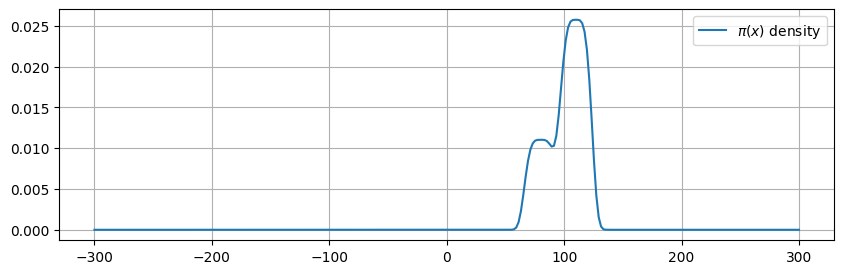

In [375]:
omega = pd.Series(np.linspace(-300, 300, 300), index = np.linspace(-300, 300, 300))

lambda_const = 0.3
kappa = find_k_for_pi(0.3)

fig, ax = plt.subplots(figsize = (10,3))
ax.plot(omega.apply(lambda x: pi_density(x, k = kappa, lambda_const = lambda_const)), label = f'$\pi(x)$ density')
ax.grid(True)
ax.legend()

### Question 2

For $q(x)$ to be suitable for rejection sampling from $\pi(x)$, we require $q(x)$ to satisfy the following conditions:

(a) $\text{supp}(\pi) \subseteq \text{supp}(q)$

(b) $\exists M \in \mathbb{R}$ such that $\pi(x) \leq Mq(x) $ for all $ x \in \text{supp}(\pi)$

It would also be desirable for $q(x)$ to be as close to $\pi(x)$ as possible in terms of shape, since acceptance probabilities $\pi(x)/Mq(x)$ could be lower and thus improve the efficiency of the algorithm. Trivially, $q(x)$ should also be easy to sample from, otherwise it wouldn't be considered as a candidate for rejection sampling.

### Question 3 and 4

Suppose we pick a gaussian density $q(x)$. We will pick $\mu, \sigma$ by hand based on the plot shown above. Intuitively, since $\pi(x)$ has two peaks of probability mass ($80$ and $110$), we will pick a $\mu$ somewhere in between, so for example $\mu = 95$. For what concerns $\sigma$, we should double-check any guess with the plot to make sure that it's suitable. For a back-of-the-envelope estimate, we could pick a $\sigma > 15$ so that values of $q(x)$ in between the two peaks of $\pi(x)$ have significant probability mass, that is, the $x \in [\mu \pm 1\sigma] = [80, 110]$.

For what concerns $M$, we can set it to:
$$ M = \max_{x \in \text{supp}(\pi)} \frac{\pi(x)}{q(x)}$$
so that we scale $q(x)$ appropriately to be always greater than $\pi(x)$ for all $x \in \text{supp}(\pi)$. Since we're going to estimate $M$ numerically, we will need a very wide and fine grid to look for the maximum. We break a $\pm$ 8-standard-deviation interval from the mean of $q(x)$ into $10^8$ steps.

In [394]:
mu = 95
sigma = optimal_sigma
grid_min = mu - 8 * sigma
grid_max = mu + 8 * sigma
steps = 10**8

omega = pd.Series(np.linspace(grid_min, grid_max, steps), index = np.linspace(grid_min, grid_max, steps))

lambda_const = 0.3
kappa = find_k_for_pi(0.3)

pi_distr = lambda x: pi_density(x, lambda_const = lambda_const, k = K)
q_distr =  lambda x: gaussian(x, mu = mu, sigma= sigma)
m_target_function = lambda x: pi_distr(x) / q_distr(x)

M_guess = max(pi_distr(omega)/q_distr(omega))
M = minimize(lambda x: -m_target_function(x), M_guess).x[0]

In [396]:
print("Estimated max of pi(x)/q(x): \t", M)

Estimated max of pi(x)/q(x): 	 2.257343300206279


Consider that M depends on our choice of parameters for $q(x)$, and the expected acceptance rate of a sampled value $X\sim q$ is:

$$ \mathbb{E}\left[ \frac{\pi(X)}{Mq(X)} \right] = \int_{\mathbb{R}} \frac{\pi(x)}{Mq(x)} q(x) dx = \frac{1}{M} \int_{\mathbb{R}} \pi(x) dx = \frac{1}{M}$$

So the larger $M$ is, the lower the probability of accepting a given sample, and the higher the computational cost of gathering a given number of samples from $\pi$ via rejection sampling from $q$. 

To illustrate the connection between the choice of $\sigma$ and $M$, we show different values of $1/M$ for different values of the $\sigma$ parameter of the proposed gaussian distribution, by computing $M$ over a grid of 100 steps for the interval $[5,100]$. We also estimate an optimal choice of sigma given our choice of $\mu = 95$.

In [403]:
sigma_grid_limits = [5, 100]
sigma_grid_units = 100
sigma_grid = np.linspace(sigma_grid_limits[0], 
                         sigma_grid_limits[1], 
                         sigma_grid_units)

omega = pd.Series(np.linspace(grid_min, grid_max, steps), index = np.linspace(grid_min, grid_max, steps))
mu = 95
lambda_const = 0.3
K = find_k_for_pi(lambda_const)

pi_distr = lambda x: pi_density(x, lambda_const = lambda_const, k = K)
exp_probs_space = []
for sigma in sigma_grid:
    
    q_distr =  lambda x: gaussian(x, mu = mu, sigma= sigma)
    m_target_function = lambda x: pi_distr(x) / q_distr(x)

    M_guess = max(pi_distr(omega)/q_distr(omega))
    M = minimize(lambda x: -m_target_function(x), M_guess).x[0]
    
    exp_probs_space.append(1/M)

optimal_sigma = sigma_grid[np.argmax(exp_probs_space)]

In [411]:
print('Estimated Optimal sigma on the grid =',optimal_sigma)

Estimated Optimal sigma on the grid = 23.232323232323232


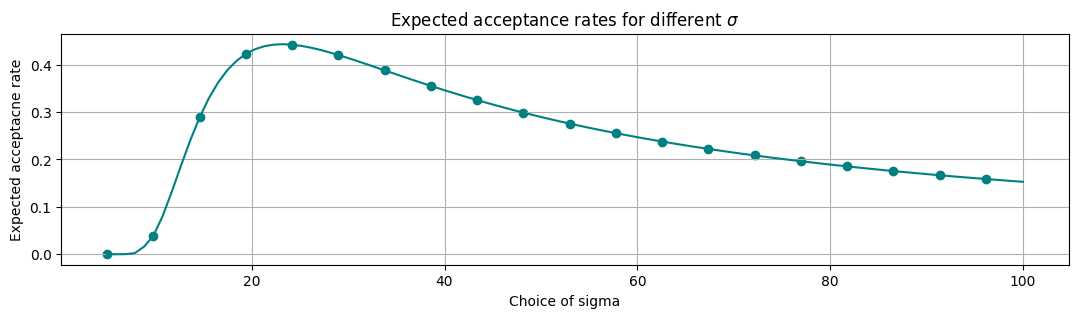

In [441]:
fig,ax = plt.subplots(nrows = 1, ncols = 1, figsize = (13,3))

ax.plot(sigma_grid, exp_probs_space, color = 'teal')
ax.scatter(sigma_grid[::5], exp_probs_space[::5], color = 'teal')
ax.set_xlabel('Choice of sigma')
ax.set_ylabel('Expected acceptacne rate')
ax.set_title('Expected acceptance rates for different $\sigma$')
ax.grid(True)

Since the focus of our analysis is not to discuss optimization methods to pick the optimal $(\mu,\sigma)$ for $q$, but rather to understand how our parameter choice relates to efficiency, we will use, as a rule of thumb, a $\sigma = 23.2323$ as suggested by the earlier analysis. 

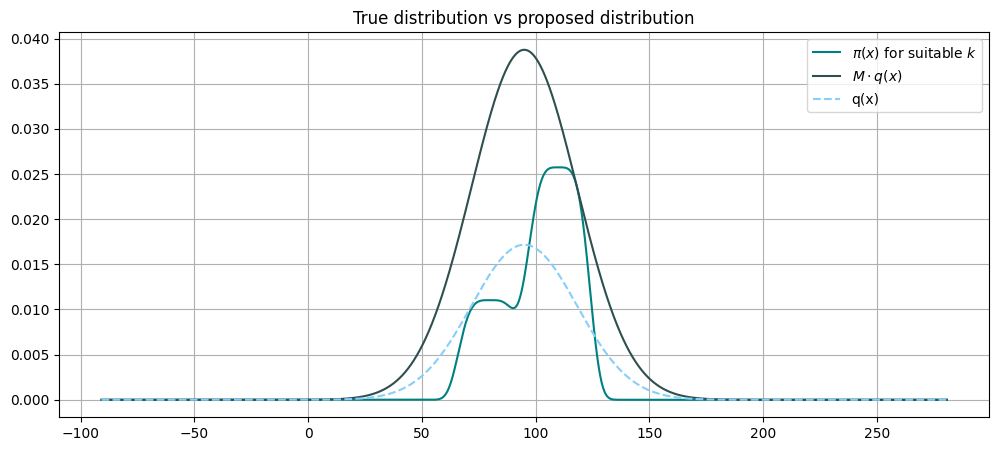

In [428]:
mu = 95
sigma = optimal_sigma
grid_min = mu - 8 * sigma
grid_max = mu + 8 * sigma
steps = 10**4

omega = pd.Series(np.linspace(grid_min, grid_max, steps), index = np.linspace(grid_min, grid_max, steps))

lambda_const = 0.3
kappa = find_k_for_pi(0.3)

pi_distr = lambda x: pi_density(x, lambda_const = lambda_const, k = K)
q_distr =  lambda x: gaussian(x, mu = mu, sigma= sigma)
m_target_function = lambda x: pi_distr(x) / q_distr(x)

M_guess = max(pi_distr(omega)/q_distr(omega))
M = minimize(lambda x: -m_target_function(x), M_guess).x[0]

fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize = (12,5))

ax.plot(pi_distr(omega), label = "$\pi(x)$ for suitable $k$", color = 'teal')
ax.plot(M * q_distr(omega), label = "$M\cdot q(x)$", color = 'darkslategray')
ax.plot(q_distr(omega), label = "q(x)", color = 'lightskyblue', linestyle = '--')
ax.set_title('True distribution vs proposed distribution')
ax.legend()
ax.grid(True)

And we run two quick checks to ensure that:

(a) $\pi(x) > Mq(x)$ for all the x we examined within the grid.

In [414]:
sum(pi_distr(omega) > (M * q_distr(omega)))

0

(b) $\pi(x)$ and $q(x)$ both integrate to 1 over $\mathbb{R}$

In [415]:
print(integrate.quad(lambda x: pi_density(x, lambda_const = lambda_const, k = K), -np.inf, np.inf)[0])
print(integrate.quad(lambda x: gaussian(x, mu = mu, sigma = sigma), -np.inf, np.inf)[0])

1.0
1.0


Next, we can proceed and implement rejection sampling.

### Question 5

Below is a very simple rejection sampling algorithm that uses the $q(x)$ with the $\mu,\sigma$ and $M$ picked above.

In [416]:
N = 10**5

mu = 95
sigma = optimal_sigma

lambda_const = 0.3
kappa = find_k_for_pi(0.3)

pi_distr = lambda x: pi_density(x, lambda_const = lambda_const, k = K)
q_distr =  lambda x: gaussian(x, mu = mu, sigma= sigma)
m_target_function = lambda x: pi_distr(x) / q_distr(x)

M_guess = max(pi_distr(omega)/q_distr(omega))
M = minimize(lambda x: -m_target_function(x), M_guess).x[0]

pi_sampled = np.array([])

while len(pi_sampled) < N:
    value = np.random.normal(loc = mu, scale = sigma, size = 1)               # samples 1 value from q(x)
    q_x = gaussian(value, mu = mu, sigma = sigma)[0]                          # computes q(x) of that value
    pi_x = pi_density(value, lambda_const = lambda_const, k = K)[0]           # computes pi(x) of that value

    acceptance_prob = min(1, pi_x/ (M * q_x))                                 # capped acc. prob. @ 1 for computational efficiency 
    try:
        accepted = np.random.choice([1,0], p = [acceptance_prob, 1 - acceptance_prob])      # accept value with probability acceptance_prob
        if accepted == 1:
            pi_sampled = np.append(pi_sampled, value)
        else:                                                                 # if rejected, move forward to next iteration
            continue
            
    except ValueError:
        print('probabilities were not non-negative')
        print('probability was', acceptance_prob)

And here is a histogram of the rejection samples against the true distribution $\pi(x)$.

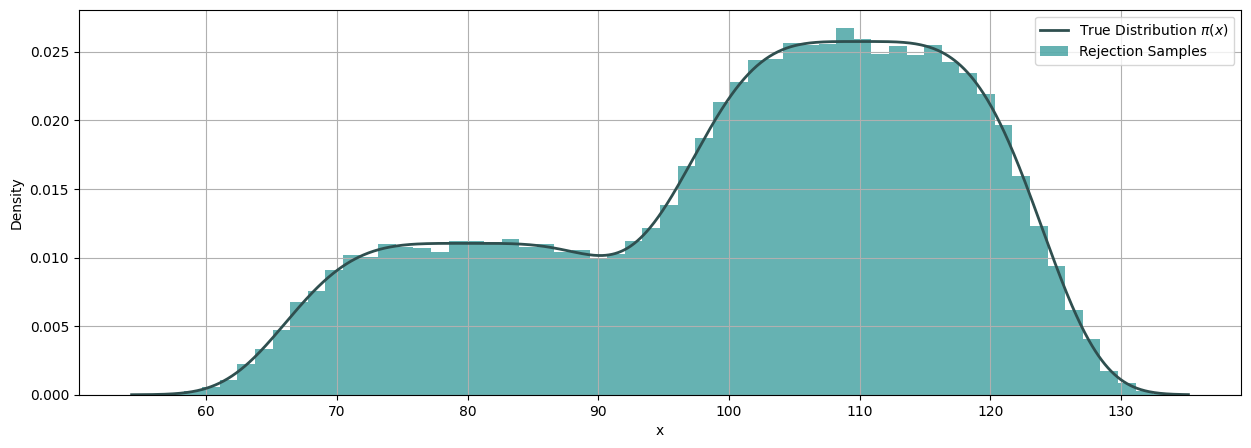

In [557]:
x = np.linspace(min(bins), max(bins), 1000)
fig, ax = plt.subplots(figsize = (15,5))

ax.plot(x, pi_distr(x), 'k', linewidth=2, label='True Distribution $\pi(x)$', color = 'darkslategray')
count, bins, ignored = ax.hist(pi_sampled, bins=60, density=True, alpha=0.6, color='teal', 
                                label='Rejection Samples')
ax.set_xlabel('x')
ax.set_ylabel('Density')
ax.legend()
ax.grid(True)

### Question 6

With the below line of code, we estimate $\mathbb{E}[\max(85-S_T,0)]$

In [431]:
pd.Series(pi_sampled).apply(lambda x: max(85-x, 0)).mean()

1.9867751748759899

# Part II - Random Walk Metropolis Hastings

### Question 1

Picking $\sigma$ is crucial here. Low sigma will make the jumps in the chain smaller and closer to zero on average and increase autocorrelation of the $X_t$. Higher sigma will make the jumps have more heterogeneous sizes but could also make acceptance probabilities more heterogeneous across timesteps. 

This is because if we pick the MH acceptance probability:
$$ \alpha(i,j) = \min\left(1, \frac{\pi(j)}{\pi(i)}\right) $$
the probability of accepting a jump is related to the difference in likelihood of $j$ compared to $i$. In our algorithm, $j = i + \varepsilon $ where $\varepsilon\sim N(0,\sigma^2)$. For example, if a sampled $\varepsilon$ is in the far-right tail of $N(0,\sigma^2)$ and $i$ was in a high-probability-mass part of $\pi$, the new proposal $j$ might be pushed to a low-probability-mass part of $\pi$, decreasing $\alpha(i,j)$. Jumps $\varepsilon$ are random, and the greater $\sigma$ we pick, the more dispersed they will be, and the $\alpha(i,j)$ will become more heterogeneous across iterations.

In [544]:
mu = 95
sigma = optimal_sigma

lambda_const = 0.3
K = find_k_for_pi(0.3)

pi_distr = lambda x: pi_density(x, lambda_const = lambda_const, k = K)
q_distr =  lambda x: gaussian(x, mu = mu, sigma= sigma)
m_target_function = lambda x: pi_distr(x) / q_distr(x)

M_guess = max(pi_distr(omega)/q_distr(omega))
M = minimize(lambda x: -m_target_function(x), M_guess).x[0]

### Question 2

Below is a simple code that runs a RMWH algorithm, starting from an initial state $X_0$ sampled from the proposal distribution. We initialize the chain with $X_0 = 95$, and we set an arbitrary a burn-in period of 10%.

In [552]:
N = 10**5
burn_in = 0.1
N = int(N * (1+burn_in))

begstate = 95
pi_sampled_MCMC = np.array([])
pi_sampled_MCMC = np.append(pi_sampled_MCMC, begstate)

np.random.seed(42)

while len(pi_sampled_MCMC) < N:
    i = pi_sampled_MCMC[-1]
    epsilon = np.random.normal(loc = 0, scale = sigma, size = 1)
    j = i + epsilon
    pi_j = pi_distr(j[0])
    pi_i = pi_distr(i)
    acceptance_prob = min(1, pi_j/pi_i)
    if acceptance_prob == 1:
        X_tplus1 = j
    else:
        X_tplus1 = np.random.choice([j[0],i], p = [acceptance_prob, 1 - acceptance_prob])
    pi_sampled_MCMC = np.append(pi_sampled_MCMC, X_tplus1)

To verify the validity of the burn-in period, we check if we get good exploration within the end of the burn-in period.

Text(0.5, 0.98, 'Plot of $X_t$ against expanding windows')

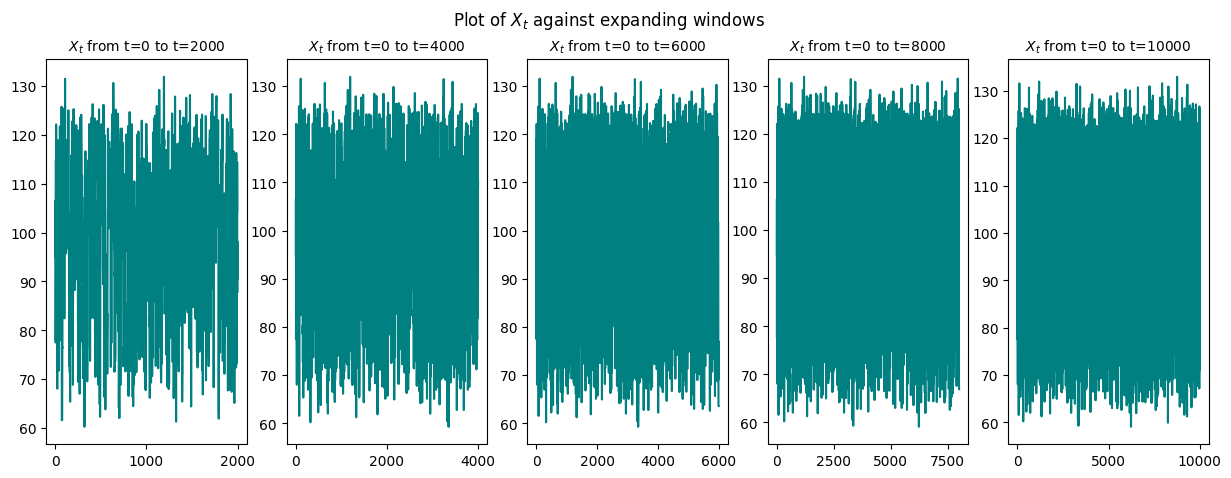

In [553]:
beg_index = 0
values_end = int(burn_in * N/(1 + burn_in))
values_breaks = 5
end_index_values = [int(values_end/values_breaks * n) for n in range(1,values_breaks+1)]
    
items_per_row = 5
fig, ax = plt.subplots(nrows = int(np.ceil(len(end_index_values)/items_per_row)), ncols = items_per_row, figsize = (15,5))
ax = ax.flatten()

for i in range(0,len(end_index_values)):
    ax[i].plot(pd.Series(pi_sampled_MCMC[beg_index:end_index_values[i]]), color = 'teal')
    ax[i].set_title(f'$X_t$ from t={beg_index} to t={end_index_values[i]}', fontsize = 10)
    # beg = beg + int(values_end/values_breaks)

fig.suptitle('Plot of $X_t$ against expanding windows')

And lastly, we plot RMWH samples against $\pi(x)$ to assess convergence.

10000


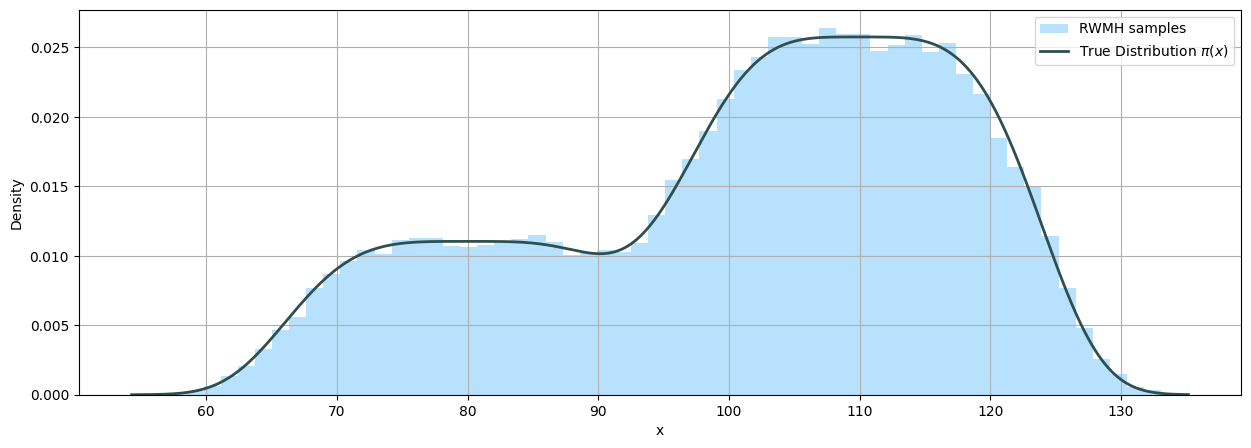

In [558]:
x = np.linspace(min(bins), max(bins), 1000)

burn_in_index = int(burn_in * (N/(1+burn_in)))
print(burn_in_index)

fig, ax = plt.subplots(figsize = (15,5))
count, bins, ignored = ax.hist(pi_sampled_MCMC[burn_in_index:], bins=60, density=True, alpha=0.6, color='lightskyblue', 
                                label='RWMH samples')
ax.plot(x, pi_distr(x), 'k', linewidth=2, label='True Distribution $\pi(x)$', color = 'darkslategray')

ax.set_xlabel('x')
ax.set_ylabel('Density')
ax.legend()
ax.grid(True)

### Question 3

We use the same approach as before to calculate the expected payoff of the european put on the stock with strike 85. We also compare it to the estimate obtained with rejection sampling.

In [559]:
print('Using rejection sampling: \t',pd.Series(pi_sampled).apply(lambda x: max(85-x, 0)).mean())
print('Using RWMH sampling: \t\t',pd.Series(pi_sampled_MCMC).apply(lambda x: max(85-x, 0)).mean())

Using rejection sampling: 	 1.9867751748759899
Using RWMH sampling: 		 1.957384028533509


### Question 4

Rejection sampling and RWMH performed similarly well in this case. We decided to spend an additional effort (and computational time) on calibrating $q(x)$ parameters in rejection sampling, and we recycled $\sigma$ for RMWH, but even hand-picking a reasonable $\sigma$ would've produced good results.

Rejection sampling is somewhat of a simpler framework to deal with. Among other reasons, this is because we're dealing with a 1-dimensional problem where picking a proposal distribution to sample from $\pi(x)$ was relatively easy. For more complex shapes of $\pi(x)$ we might've ended up either having trouble selecting a proposal, or picking a proposal that would've led to very low acceptance rates. For multi-dimensional simulation problems, RWMH would also be somewhat simpler to implement. As an example, consider picking the problem of picking a proposal $q(\textbf{x})$ where $x \in \mathbb{R}^n$ for rejection sampling from $\pi(\textbf{x})$. Finding an <u> efficient </u> constant $M$ to scale $q(\textbf{x})$ to make sure that $\pi(\textbf{x}) < Mq(\textbf{x})$ would require to solve an optimization problem in $n$ dimensions, which may be cumbersome. On the other hand, with RMWH, any proposal will work, and no bounding constant is needed.